<a href="https://colab.research.google.com/github/nicolaiberk/llm_ws/blob/main/02_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro to embedding manipulation with `gensim`

In [2]:
!pip install gensim # restart after installation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 88.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 15.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.0
    Uninstalling scipy-1.16.0:
      Successfully uninstalled scipy-1.16.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
openc

## Word Embeddings

In [1]:
## we load a 100-dimensional GloVe model trained on Wikipedia data
import gensim.downloader as api
wv = api.load('glove-wiki-gigaword-100') # small model so we don't have to wait too long...

[==================================================] 100.0% 128.1/128.1MB downloaded


In [2]:
wv['ziti'] # what do our embeddings look like?

array([ 0.049439 ,  0.33049  , -0.62916  ,  0.05941  , -0.070866 ,
       -0.31198  ,  1.0051   , -0.36994  ,  0.51071  ,  0.88759  ,
        0.30675  ,  0.41871  , -0.20705  ,  0.54854  ,  0.2315   ,
       -0.10115  , -0.44656  ,  0.022504 ,  0.31798  ,  0.44769  ,
       -0.50513  ,  0.34741  , -0.069257 ,  0.22331  ,  0.41969  ,
        0.27958  ,  0.0037731, -0.22206  , -0.60191  , -0.67105  ,
        0.1164   ,  0.099292 ,  0.16863  , -0.69876  ,  0.13203  ,
        0.14845  ,  0.020125 , -0.40887  ,  0.15019  , -0.25258  ,
        0.69223  , -0.24897  ,  0.047037 , -0.33101  , -0.16142  ,
        0.10763  , -0.06854  , -0.29817  ,  0.15847  ,  0.92439  ,
        0.52995  ,  0.89365  ,  0.56876  , -0.2421   , -0.78985  ,
        0.75897  ,  0.53027  ,  0.53722  , -0.94077  ,  0.0013162,
       -0.12927  , -0.10485  , -0.059788 , -0.56039  , -0.38289  ,
       -0.43905  ,  0.02313  , -0.27358  , -0.086559 , -0.54393  ,
       -0.49323  ,  0.14044  ,  0.50186  ,  0.11039  , -0.4033

### Get most similar words

In [ ]:
## so what are 'ziti' according to our model? Let's check the most similar embeddings:
print(wv.most_similar(positive=['ziti'], topn=5))

[('rigatoni', 0.7073923349380493), ('penne', 0.6969299912452698), ('focaccia', 0.6311710476875305), ('rotini', 0.6265588402748108), ('scrod', 0.6251025199890137)]


In [ ]:
## you can assess the cosine similarity with
wv.similarity('ziti', 'penne')

0.69693005

In [ ]:
# Whereas
wv.similarity('ziti', 'banana')

0.15077041

In [ ]:
# and
wv.similarity('ziti', 'car')

-0.2821738

In [ ]:
## You can calculate with these embeddings:
wv_london = wv['paris'] - wv['france'] + wv['england']
print(wv.most_similar(positive=[wv_london], topn=5))

[('london', 0.7929531931877136), ('england', 0.7346792221069336), ('melbourne', 0.7304184436798096), ('sydney', 0.7011193037033081), ('perth', 0.6856114864349365)]


In [ ]:
## Though it does not always work perfectly
wv_queen = wv['king'] + wv['women'] - wv['men']
print(wv.most_similar(positive=[wv_queen], topn=5))

[('king', 0.8731269836425781), ('queen', 0.756426215171814), ('monarch', 0.7043204307556152), ('prince', 0.6424739360809326), ('kingdom', 0.6367932558059692)]


In [ ]:
## you can also use the inbuilt function to get weighted averages
print(wv.most_similar(positive=['women', 'king'], negative=['men'], topn=5))

[('queen', 0.7415665984153748), ('monarch', 0.7021745443344116), ('prince', 0.6327081322669983), ('kingdom', 0.6294623017311096), ('elizabeth', 0.611503005027771)]


In [ ]:
## other cute functions
print(wv.doesnt_match(['fire', 'water', 'land', 'sea', 'air', 'car']))

car


### Reduce dimensions & visualize

### Use embeddings to scale words

In [145]:
## you can use the inbuilt gensim function to assess the similarity of embeddings
wv.similarity('nurse', 'woman')

0.61394423

In [146]:
## ...or calculate by hand using numpy
from numpy import dot
from numpy.linalg import norm

def cos_sim(a, b):
    return dot(a, b)/(norm(a)*norm(b))

cos_sim(wv['nurse'], wv['woman'])

0.6139443

In [117]:
## define your dictionaries (ideally a bit larger than three words)
female_words = ['female', 'woman', 'feminine']
male_words = ['male', 'man', 'masculine']

In [118]:
## bonus: you can extend your dictionaries with embeddings!
wv.most_similar(positive=rich_words, topn=5) # you could add relevant terms to your dictionary

[('fortune', 0.6519295573234558),
 ('richest', 0.6483082175254822),
 ('money', 0.620699405670166),
 ('vast', 0.6197865605354309),
 ('businessman', 0.6197428107261658)]

In [147]:
## create mean vectors for your concepts of interest
female_vec = np.mean(wv[female_words], axis = 0)
male_vec = np.mean(wv[male_words], axis = 0)

In [ ]:
## what does this vector look like?
female_vec.shape

In [148]:
cos_sim(wv['nurse'], female_vec)

0.5050166

In [150]:
cos_sim(wv['nurse'], male_vec)

0.40162915

In [152]:
cos_sim(wv['banker'], female_vec)

0.20321447

In [151]:
cos_sim(wv['banker'], male_vec)

0.23747267

In [153]:
## cosine similarity difference
nurse_mf_cos = cos_sim(wv['nurse'], female_vec) - cos_sim(wv['nurse'], male_vec)
teacher_mf_cos = cos_sim(wv['teacher'], female_vec) - cos_sim(wv['teacher'], male_vec)
lifeguard_mf_cos = cos_sim(wv['lifeguard'], female_vec) - cos_sim(wv['lifeguard'], male_vec)
banker_mf_cos = cos_sim(wv['banker'], female_vec) - cos_sim(wv['banker'], male_vec)
miner_mf_cos = cos_sim(wv['miner'], female_vec) - cos_sim(wv['miner'], male_vec)

In [174]:
nurse_mf_cos # more female

0.103387475

In [175]:
teacher_mf_cos

0.023278862

In [176]:
lifeguard_mf_cos

0.0648001

In [177]:
banker_mf_cos

-0.0342582

In [178]:
miner_mf_cos # more male

-0.006028235

We can also use the dot product to a given vector (= position of vector a on a given vector b):

In [180]:
## start by adding another scale
rich_words = ['rich', 'wealthy', 'wealth', 'billionaire']
poor_words = ['poor', 'broke', 'poverty', 'beggar']

rich_vec = np.mean(wv[rich_words], axis = 0)
poor_vec = np.mean(wv[poor_words], axis = 0)

In [181]:
## define axes
gender_axis = female_vec - male_vec
rich_axis = rich_vec - poor_vec

In [182]:
## calculate dot product for relative position on scale
np.dot(wv['nurse'], gender_axis)

3.4711077

In [183]:
import numpy as np
import pandas as pd

scaled_occupations = pd.DataFrame(
    [['Nurse', 'Teacher', 'Lifeguard', 'Banker', 'Miner'],
    [
        np.dot(wv['nurse'], gender_axis),
        np.dot(wv['teacher'], gender_axis),
        np.dot(wv['lifeguard'], gender_axis),
        np.dot(wv['banker'], gender_axis),
        np.dot(wv['miner'], gender_axis)
    ],
    [
        np.dot(wv['nurse'], rich_axis),
        np.dot(wv['teacher'], rich_axis),
        np.dot(wv['lifeguard'], rich_axis),
        np.dot(wv['banker'], rich_axis),
        np.dot(wv['miner'], rich_axis)
    ]]
).T.rename(columns={0:'Occupation', 1:'Gender score', 2:'Economic Score'})

In [184]:
scaled_occupations

,Occupation,Gender score,Economic Score
0,Nurse,3.471108,-5.989534
1,Teacher,1.538335,-2.988986
2,Lifeguard,1.581818,-6.319327
3,Banker,-0.403989,9.930306
4,Miner,0.248439,3.270799


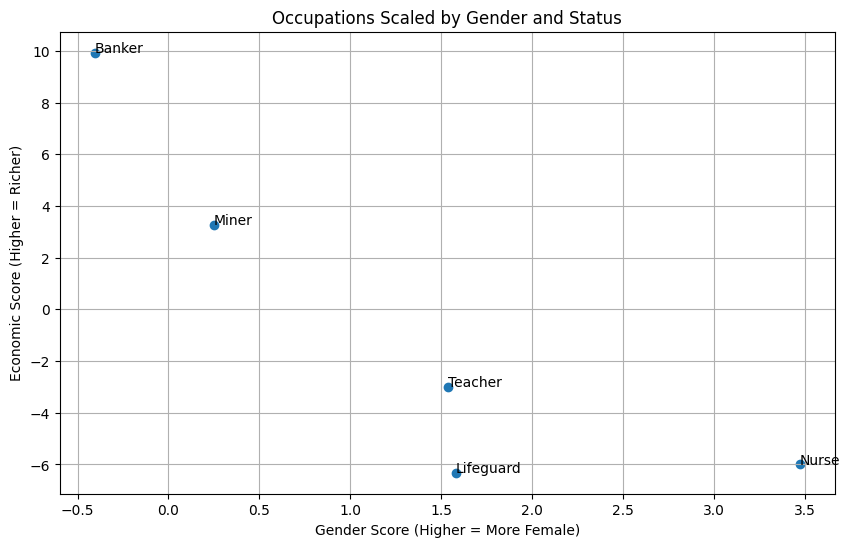

In [185]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(scaled_occupations['Gender score'], scaled_occupations['Economic Score'])

# Add labels and title
plt.xlabel('Gender Score (Higher = More Female)')
plt.ylabel('Economic Score (Higher = Richer)')
plt.title('Occupations Scaled by Gender and Status')

# Add text labels for each point
for i, row in scaled_occupations.iterrows():
    plt.text(row['Gender score'], row['Economic Score'], row['Occupation'])

plt.grid(True)
plt.show()

In [186]:
## in practice highly correlated (cos_sim is just a normalized dot product)
scaled_occupations['cos_dif_gender'] = [nurse_mf_cos, teacher_mf_cos, lifeguard_mf_cos, banker_mf_cos, miner_mf_cos]
scaled_occupations[['Gender score', 'cos_dif_gender']].corr()

,Gender score,cos_dif_gender
Gender score,1.000000,0.963181
cos_dif_gender,0.963181,1.000000


### Train a new model

We'll use an adapted dataset of dialogue in the Simpsons from [Kaggle](https://www.kaggle.com/datasets/prashant111/the-simpsons-dataset?resource=download&select=simpsons_script_lines.csv).

In [ ]:
## load data
import pandas as pd
dataset = pd.read_csv('https://www.dropbox.com/scl/fi/n5ffxvm4qyjkp8ws7qgoq/simpsons_script_lines_clean.csv?rlkey=gfliitwgi8cqsjxlcdmmdwtym&dl=1')
dataset.head()

,id,raw_character_text,spoken_words
0,9549,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,9550,Lisa Simpson,Where's Mr. Bergstrom?
2,9551,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,9552,Lisa Simpson,That life is worth living.
4,9553,Edna Krabappel-Flanders,The polls will be open from now until the end ...


In [ ]:
## clean the texts (very rough here)
dataset['cleaned_text'] = dataset['spoken_words'].str.replace('[^a-zA-Z \d]','', regex=True) # remove anything that is not a letter or whitespace
dataset['cleaned_text'] = dataset['cleaned_text'].str.lower() # lowercase
dataset['cleaned_text'] = dataset['cleaned_text'].str.replace('\d+', '') # remove multiple whitespaces

In [ ]:
dataset.cleaned_text.head()

,cleaned_text
0,no actually it was a little of both sometimes ...
1,wheres mr bergstrom
2,i dont know although id sure like to talk to h...
3,that life is worth living
4,the polls will be open from now until the end ...


In [ ]:
## filter empty rows and enforce string
dataset = dataset[dataset['cleaned_text'] != '']
dataset['cleaned_text'] = dataset['cleaned_text'].astype(str)

In [ ]:
## how many texts are left?
dataset.shape

(158250, 4)

In [ ]:
## create a list of lists of words by splitting along whitespaces
sentences = [s.split(" ") for s in dataset['cleaned_text']]

In [ ]:
sentences[1]

['wheres', 'mr', 'bergstrom']

In [ ]:
## load dataset (use an iterator for larger datasets: https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#training-your-own-model)
from gensim.models import Word2Vec

## estimate a model and save
model = Word2Vec(
    sentences=sentences,
    vector_size=100,  # number of dimensions of word embeddings
    window=5,         # number of context words in either direction to include
    min_count=5,      # how often must a word appear to enter the corpus?
    workers=4         # how many CPUs should be used to fit the model?
    )
model.save("simpsons.w2v.model")

In [ ]:
## assess model
model.wv.most_similar('homer', topn=5)

[('bart', 0.8287650942802429),
 ('marge', 0.8060054779052734),
 ('lisa', 0.7775300145149231),
 ('abe', 0.7122818231582642),
 ('grampa', 0.7074202299118042)]

In [ ]:
model.wv.most_similar('tavern', topn=5)

[('retirement', 0.8721364736557007),
 ('waterfront', 0.8637022972106934),
 ('mount', 0.863527238368988),
 ('spiritual', 0.8470531702041626),
 ('churches', 0.8451192378997803)]

In [ ]:
model.wv.most_similar('skateboard', topn=5)

[('jacket', 0.920958936214447),
 ('buttocks', 0.9046000838279724),
 ('flapping', 0.8933189511299133),
 ('bret', 0.8926150798797607),
 ('palm', 0.8921723365783691)]

## Document Embeddings

## Speaker Embeddings